# Goal and Outcomes Revisited: 
Initially we had not been very explicit with our goals and expectations. To alleviate this we have decided to deviate somewhat from our initial project proposal. The purpose and goal of our analysis is to find correlations between changes in population and changes in environment through the use of satellite images and other feature sets that correlate to the aforementioned region. Ideally what we expect to find by applying pixel by pixel hue analysis to the images are changes in infrastructure and region density that would contribute to a change in the region's average color. We can then find a correlation between changes in the color saturation from the images and the changes happening within the chosen feature set. Not identifying any expected changes would not be a failure of our analysis because factors such as population density in regions and the differences between the selected location all may play a part in our observations. Those differences may also give some other unintended insight about the potential factors affecting our study. 


# Data: 
While our initial focus was posited on the satellite analysis, we have decided to shift towards comparisons with another data set. More specifically looking at cities in the United States and changes in their population. We have two sources for this data one is from  https://simplemaps.com/data/us-cities and contains population location and more features. The other is from, https://www.downloadexcelfiles.com/us_en/download-excel-file-list-state-capitals-united-states, and just expands on our initial dataset. The population values for cities are from varying years and this allows us to see the changes accurately and is the main data we are testing against. The satellite images contain visual information about urban features and this is conveyed in its hue saturation. The red, blue, and green values within the picture are objects and their average color values as seen from space. So if an area has more of a certain type of object in a region we can expect to see that represented, if there are enough of the objects, by an increase of that object's color hue in that image. So we are going to take photos from U.S cities from varying dates to test our hypothesis about correlations between these changes and the environment.

In [17]:
#load csv of city coordinates
#loaded dataset parsed by wether row is capital or not
import pandas as pd

us_cities = pd.read_csv("us_cities_v2.csv")
us_cities.loc[us_cities['capital']]

,city,state_id,state,county,lat,long,population,density,source,military,incorporated,capital,timezone,ranking,zips
7,Atlanta,GA,Georgia,Fulton,33.7627,-84.4224,5449398,1441,polygon,False,True,True,America/New_York,1,56
8,Washington,DC,District of Columbia,District of Columbia,38.9047,-77.0163,5379184,4457,polygon,False,True,True,America/New_York,1,292
9,Boston,MA,Massachusetts,Suffolk,42.3188,-71.0846,4688346,5532,polygon,False,True,True,America/New_York,1,53
10,Phoenix,AZ,Arizona,Maricopa,33.5722,-112.0891,4219697,1253,polygon,False,True,True,America/Phoenix,1,82
17,Denver,CO,Colorado,Denver,39.7621,-104.8759,2876625,1831,polygon,False,True,True,America/Denver,1,54
26,Sacramento,CA,California,Sacramento,38.5667,-121.4683,1898019,2029,polygon,False,True,True,America/Los_Angeles,1,86
31,Austin,TX,Texas,Travis,30.3004,-97.7522,1687311,1181,polygon,False,True,True,America/Chicago,1,71
35,Indianapolis,IN,Indiana,Marion,39.7771,-86.1458,1588961,935,polygon,False,True,True,America/Indiana/Indianapolis,1,53
36,Columbus,OH,Ohio,Franklin,39.9862,-82.9850,1562009,1582,polygon,False,True,True,America/New_York,1,54
41,Providence,RI,Rhode Island,Providence,41.8230,-71.4187,1203230,3773,polygon,False,True,True,America/New_York,1,12


# Data Processing: 
Processing and normalizing the data may have been a large reason as to why we changed our project scope. As we began actually processing the returned queries, we found that there was a lot more cloud obfuscation than we had expected. So we had to come up with a method to parse out the images we find that are too cloudy. We did this by doing pixel by pixel analysis to ascertain what percentage of the image was white. The images, if they contained clouds, the clouds would dominate the photo with a mostly pure white saturation. So if enough of the image was actually white then we knew to exclude that datapoint and use another. This is not expected to be an issue in terms of conflicting dates of analysis versus what dates are the pictures we actually analyzed are taken. Changes in population can potentially take months and years to happen and because of this, this should cause problematic outcomes. To minimize time taken to collect the data and write queries, we chose to implement a script to dynamically make calls to our selected api. The calls were being made by processing our dataset containing city information and coordinates. The program then pushes those coordinates to the api and writes the responses to individual files within our contains images folder. We wrote a script that filters out the images that are too cloudy and saves those chosen images to a folder so we could more easily manipulate the images without having to worry about nasa’s api hitting its query limit. The decision was made to limit the images to 32 x 32, although we may choose to limit these even more to allow for accurate processing. This way we could more easily collect and normalize the data. By also limiting ourselves to only U.S capitals we can clearly define the scope of our analysis. Choosing to only select two images per capita will allow to see an initial condition and an after condition to test against. The goal is expected for the outcome to confirm the correlation between population and color values in a region. 


In [ ]:
#this is the script to filter cloudy images 
#The full code can be found the collector.ipynb within the contained folder
import os, cv2, requests, base64, imageio
from PIL import Image
from io import BytesIO
import seaborn as sn
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def next_mo(date):
    mo = '0' + str(int(date[5:7]) + 1)
    if len(mo) > 2:
        mo = mo[1:]
    date = date[:5] + mo + date[7:]
    return date

def is_cloudy(img):
    #Takes Image object, returns bool if it meets 'cloudy' criteria
    k = 75 #Threshold coeff.
    
    hist = img.histogram()
    Rm = np.mean(hist[:256])
    Gm = np.mean(hist[256:512])
    Bm = np.mean(hist[512:])
    W = [hist[255], hist[511], hist[-1]]
    
    if W[0] > k*Rm or W[1] > k*Gm or W[2] > k*Bm:
        return True
    else:
        return False

#Load lat and long csv
us_cities = pd.read_csv("us_cities_v2.csv")
us_cities

capitals = us_cities.loc[us_cities['capital']]
capitals = capitals.reset_index(drop=True)

site = "https://api.nasa.gov/planetary/earth/imagery?"
key1 = "II3XUxmGYfFKmyapNeXjrH3Os3ILNhQScjW6bbMT"
key2 = "07b9v4Pg29fysvhDf1q6x0UyOaGZxXIfryIv9PKO"

dates = ['2016-05-01', '2019-05-01']

counter = 0
for date in dates:
    for i, city in capitals.iterrows():
        date_ = date
        
        # Query API for capital image
        url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                  "&dim=.1&date=" + date + "&api_key=" + key1
        
        response = requests.get(url)
        print("Ok?",response.ok,'i =',i)
            
        if response.ok:
            img = Image.open(BytesIO(response.content))
            cloudy = is_cloudy(img)
            print(cloudy)
                
            attempts = 0
            while cloudy and attempts <= 4:
                #NOTE - Selects nearest date
                date = next_mo(date)
                    
                url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                    "&dim=.1&date=" + date + "&api_key=" + key1
                response = requests.get(url)
                    
                img = Image.open(BytesIO(response.content))
                    
                cloudy = is_cloudy(img)
                attempts += 1
                    
            if response.ok:
                img = img.resize((32,32))
                    
                name = '_' + city['city'].replace(' ','_') + '_' + date.replace('-','_') + '.png'
                #saves images to folder with noramalized name 
                #img.save(name)
                date = date_
                counter += 1
                    
            if attempts > 4:
                print(city['city'], date)
                date = date_
print(counter)

# Ethical Considerations:
Our original perspective on ethical considerations has not changed drastically. We are definitely avoiding making any claims about cities in terms of population classifications and how it relates socioeconomically or what analyzed values correlate to in terms of quality or perceived superiority or inferiority. The only claims we are trying to make are in relation to population and changes in visual features as observed from our data source. 
An ethical consideration that we did not touch on in our project proposal was our sources. The resources we utilize for our project are allowed within the license and terms of the dataset. This is only based on certain conditions, such as using the data for academic purposes. The dataset is ethical to use as long as we properly source where we collected it from. This can be seen by reading the uses and use clauses as defined in the data license. 
Sources: 
https://simplemaps.com/data/us-cities.csv 
https://www.downloadexcelfiles.com/us_en/download-excel-file-list-state-capitals-united-states

# Exploratory Analysis and Approach: 
Shifting our focus to population changes we can look at the population as our response variable. We can cross reference that variable with our processed image data to test if our hypothesis works and if there is a viable correlation between the two. The way we are analyzing our image set is by mapping the red, blue, green color values to a histogram. The intensity of the histogram gives a good visual tool to understand the data being explored. Variances in color concentrations can indicate a variety of things, but we are trying to isolate its specific relationship with the analyzed regions' population. To do this we must compare found values to expected values based on the change in the location over the given period. Establishing a control will allow us to specify what changes we can expect with a city's growth due to population increase. We expect to find a linear change in the color values based on the changes in topography due to population increase. Something to consider is density of the new population and whether they tend to migrate towards dense populace centers or expand out on the cities outlying regions. Even if population growth is only increasing in density we should still expect so see some changes in color saturation for that growing region.


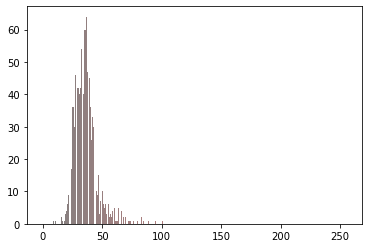

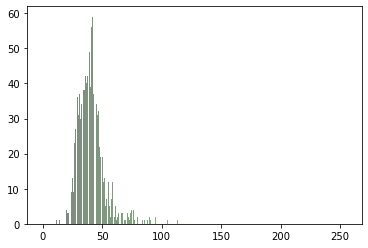

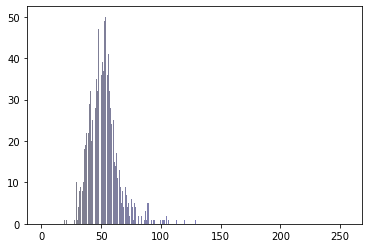

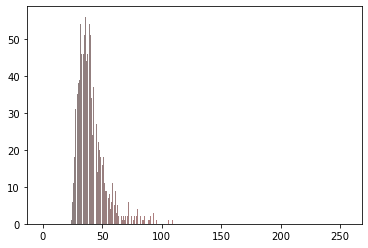

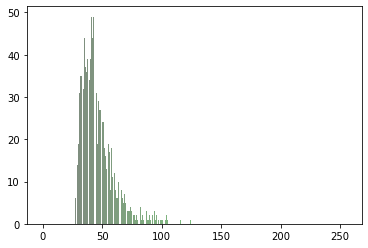

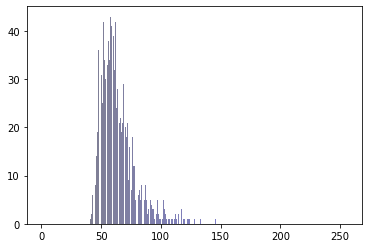

In [25]:
#show how we can proccess images as histograms
#Takes Image object, returns bool if it meets 'cloudy' criteria
#side by side of same location but different dates plotted as heat map
k = 75 #Threshold coeff.

img = Image.open('images/_Albany_2017_03_01.png')
img2 = Image.open('images/_Albany_2020_05_01.png')

hist = img.histogram()
hist2 =img2.histogram()

#iterate through img histogram to find rgb values
Rm = hist[0:256]
Gm = hist[256:512]
Bm = hist[512:768]

Rm2 = hist2[0:256]
Gm2 = hist2[256:512]
Bm2 = hist2[512:768]


def Red(R): 
    return '#%02x%02x%02x'%(R,0,0)
def Green(G): 
    return '#%02x%02x%02x'%(0,G,0)
def Blue(B):
    return '#%02x%02x%02x'%(0,0,B)

for i in range(0, 256):
    plt.bar(i, Rm[i], color = Red(i), alpha = .5)
    plt.figure(1) # plot red
for i in range(0, 256):
    plt.bar(i, Gm[i], color = Green(i), alpha = .5)
    plt.figure(2) # plot green
for i in range(0, 256):
    plt.bar(i, Bm[i], color = Blue(i), alpha = .5)
    plt.figure(3) #plot blue
plt.show()

for i in range(0, 256):
    plt.bar(i, Rm2[i], color = Red(i), alpha = .5)
    plt.figure(1) # plot red
for i in range(0, 256):
    plt.bar(i, Gm2[i], color = Green(i), alpha = .5)
    plt.figure(2) # plot green
for i in range(0, 256):
    plt.bar(i, Bm2[i], color = Blue(i), alpha = .5)
    plt.figure(3) #plot blue
plt.show()

# Analysis Methodology
The methods we implement to actually analyze the data include classifying each data feature set. How we classify it matters because we expect different outcomes based on described attributes. Different locations may have changes different from other locations. This can be due to geographical features or the natural environment of the specified area. It’s important to understand and anticipate certain analytical failings and be able to understand the underlying cause of them. The results may seem to indicate one thing, but there may be others unforeseen factors impacting our analysis. Being thorough in our interpretation of results is important to testing the accuracy of our claims. As such analytical our methodologies implement those restraints in mind to keep our results giving us the appropriate answer based on the featureset. 